Mutant | Reactant Magnitude | Product Magnitude
----------------------------------------------
A74G | 10.4062 | 6.7631
E143S | 10.2697 | 6.7651
F139L | 10.2792 | 6.7543
F48Y | 10.6731 | 7.6214
G102S | 10.5193 | 6.6788
H144Q | 10.4030 | 6.7785
H177Q | 10.3920 | 6.6654
I24L | 10.6563 | 6.9409
K87T | 10.3867 | 7.0381
N107S | 10.4460 | 6.3115
R181S | 10.4029 | 7.1780
R99C | 10.3343 | 6.4229
S47A | 10.2962 | 7.1382
S4R | 10.4324 | 6.8908
T178A | 10.3197 | 6.5290
T52A | 10.4978 | 7.2231
T60A | 10.5041 | 7.5259
Y104F | 10.3763 | 6.1785

Center of Mass for Sec49:
--------------------------
A74G | Reactant COM: [36.27440529 36.05801251 35.67252788] | Product COM: [37.09898085 36.86208948 36.91721291]
E143S | Reactant COM: [36.23496263 36.02510691 35.65233615] | Product COM: [36.97207424 36.74222345 36.78931303]
F139L | Reactant COM: [36.22890661 36.01861127 35.64457626] | Product COM: [37.08222682 36.82340197 36.88756683]
F48Y | Reactant COM: [36.46670973 36.28970487 35.83738406] | Product COM:

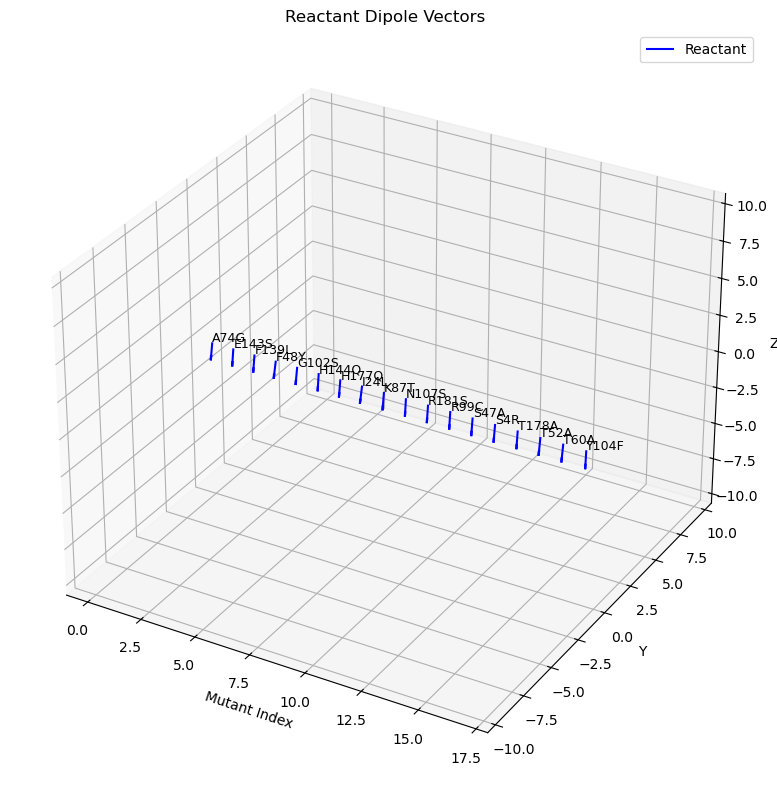

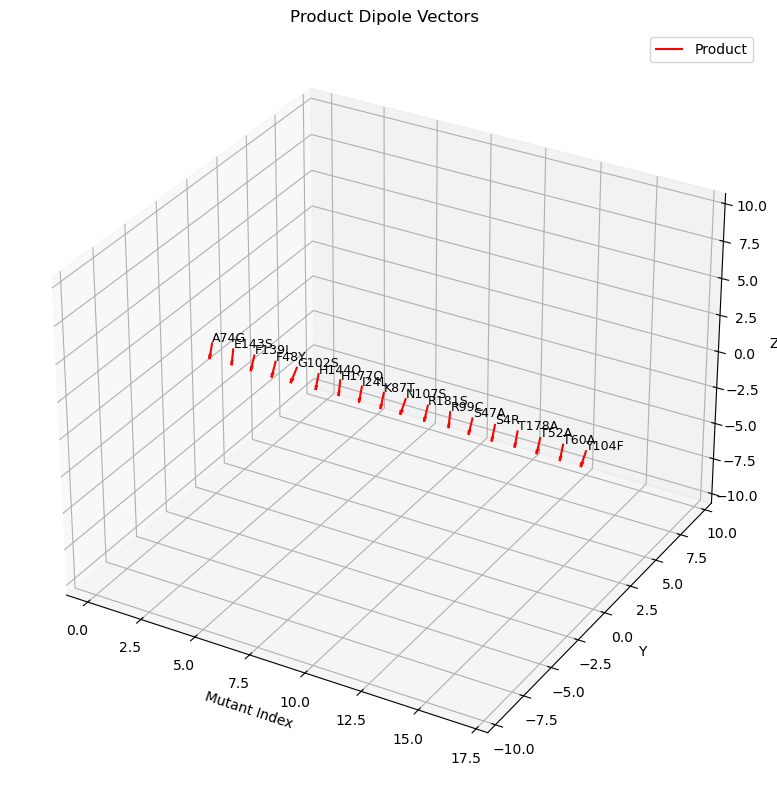

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Charges for state 1 (reactant) and state 2 (product)
charges_reactant = np.array([
    -0.335, 0.155, 0.06, 0.06, 0.06, 0.14, 0.06, -0.5, 0.3,
    -0.418, -0.418, 0.418, 0.418,
    -0.76, 0.38, 0.38, 0.5, -0.5,
    -0.12, 0.06, 0.06, -0.12, 0.06, 0.06
])
charges_product = np.array([
    -0.9, 0.418, -0.3, 0.1, 0.1, 0.14, 0.06, -0.5, 0.3,
    -0.418, -0.418, 0.418, 0.418,
    -0.4965, 0.48, 0.48, 0.2858, -0.503,
    -0.12, 0.06, 0.06, 0.2157, 0.06, 0.06
])

num_atoms = 24
sec49_indices = np.arange(0, 9)  # Atoms corresponding to Sec49

def extract_first_24_coordinates(df):
    coord_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y') or col.endswith('_z')]
    coord_columns = sorted(coord_columns, key=lambda x: (x.rsplit('_', 1)[-1], df.columns.get_loc(x)))
    coord_triplets = [coord_columns[i:i+3] for i in range(0, len(coord_columns), 3)]
    coord_triplets = coord_triplets[:num_atoms]  # only first 24 atoms
    coords = []

    for triplet in coord_triplets:
        x = df[triplet[0]].values
        y = df[triplet[1]].values
        z = df[triplet[2]].values
        coords.append(np.stack([x, y, z], axis=1))

    coords = np.stack(coords, axis=1)  # shape (n_frames, n_atoms, 3)
    return coords

def compute_center_of_mass(coords, charges, atom_indices):
    masses = np.abs(charges[atom_indices])
    total_mass = np.sum(masses)
    centers_of_mass = []
    for frame in coords:
        selected_coords = frame[atom_indices]
        weighted_coords = selected_coords * masses[:, np.newaxis]
        com = np.sum(weighted_coords, axis=0) / total_mass
        centers_of_mass.append(com)
    return np.array(centers_of_mass)

def compute_avg_dipole(filepaths, charges, return_com=False):
    dipoles = []
    all_coms = []
    for filepath in filepaths:
        try:
            df = pd.read_csv(filepath)
            coords = extract_first_24_coordinates(df)
            if return_com:
                coms = compute_center_of_mass(coords, charges, sec49_indices)
                all_coms.append(np.mean(coms, axis=0))
            for frame in coords:
                dipole = np.sum(frame * charges[:, np.newaxis], axis=0)
                dipoles.append(dipole)
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
    avg_dipole = np.mean(dipoles, axis=0) if dipoles else np.array([0.0, 0.0, 0.0])
    avg_com = np.mean(all_coms, axis=0) if all_coms else np.array([0.0, 0.0, 0.0])
    return (avg_dipole, avg_com) if return_com else avg_dipole

def compute_dipole_magnitude(dipole):
    return np.linalg.norm(dipole)

# Directory setup
base_path = "/home/hp/results/MOUSE/level2"
mutants = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

reactant_dipoles = {}
reactant_coms = {}
product_dipoles = {}
product_coms = {}
reactant_magnitudes = {}
product_magnitudes = {}

for mutant in mutants:
    reactant_csvs = []
    product_csvs = []
    for i in range(16):
        traj_path = os.path.join(base_path, mutant, f"traj{str(i).zfill(2)}")
        reactant_file = os.path.join(traj_path, "reactant.csv")
        product_file = os.path.join(traj_path, "product.csv")
        if os.path.isfile(reactant_file):
            reactant_csvs.append(reactant_file)
        if os.path.isfile(product_file):
            product_csvs.append(product_file)

    if reactant_csvs:
        dipole, com = compute_avg_dipole(reactant_csvs, charges_reactant, return_com=True)
        reactant_dipoles[mutant] = dipole
        reactant_coms[mutant] = com
        reactant_magnitudes[mutant] = compute_dipole_magnitude(dipole)
    if product_csvs:
        dipole, com = compute_avg_dipole(product_csvs, charges_product, return_com=True)
        product_dipoles[mutant] = dipole
        product_coms[mutant] = com
        product_magnitudes[mutant] = compute_dipole_magnitude(dipole)

# Print Dipole Magnitudes
print("Mutant | Reactant Magnitude | Product Magnitude")
print("----------------------------------------------")
for mutant in sorted(set(reactant_dipoles) | set(product_dipoles)):
    reactant_mag = reactant_magnitudes.get(mutant, 0.0)
    product_mag = product_magnitudes.get(mutant, 0.0)
    print(f"{mutant} | {reactant_mag:.4f} | {product_mag:.4f}")

# Print Center of Mass for Sec49
print("\nCenter of Mass for Sec49:")
print("--------------------------")
for mutant in sorted(set(reactant_coms) | set(product_coms)):
    r_com = reactant_coms.get(mutant, np.zeros(3))
    p_com = product_coms.get(mutant, np.zeros(3))
    print(f"{mutant} | Reactant COM: {r_com} | Product COM: {p_com}")

# Create a pandas DataFrame
data = {
    'Mutant': sorted(set(reactant_dipoles) | set(product_dipoles)),
    'Reactant Magnitude': [reactant_magnitudes.get(m, 0.0) for m in sorted(set(reactant_dipoles) | set(product_dipoles))],
    'Product Magnitude': [product_magnitudes.get(m, 0.0) for m in sorted(set(reactant_dipoles) | set(product_dipoles))]
}
df = pd.DataFrame(data)
print("\nTable of Magnitudes:")
print(df)

# 3D quiver plot for Reactant Dipoles
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')

origin = np.zeros((3,))
scale = 0.2
dipole_magnitudes = np.array([np.linalg.norm(d) for d in list(reactant_dipoles.values()) + list(product_dipoles.values())])
max_magnitude = np.max(dipole_magnitudes)

for i, mutant in enumerate(sorted(reactant_dipoles)):
    r = reactant_dipoles[mutant]
    r_normalized = r / np.linalg.norm(r) * (scale * max_magnitude) if np.linalg.norm(r) != 0 else r
    ax1.quiver(i, 0, 0, r_normalized[0], r_normalized[1], r_normalized[2], color='blue', label='Reactant' if i == 0 else "", length=1, normalize=True)
    ax1.text(i, 0, 0, mutant, fontsize=9)

ax1.set_xlabel('Mutant Index')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Reactant Dipole Vectors')
ax1.set_xlim([-1, len(reactant_dipoles)])
ax1.set_ylim([-max_magnitude, max_magnitude])
ax1.set_zlim([-max_magnitude, max_magnitude])
ax1.legend()
plt.tight_layout()

# 3D quiver plot for Product Dipoles
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')

for i, mutant in enumerate(sorted(product_dipoles)):
    p = product_dipoles[mutant]
    p_normalized = p / np.linalg.norm(p) * (scale * max_magnitude) if np.linalg.norm(p) != 0 else p
    ax2.quiver(i, 0, 0, p_normalized[0], p_normalized[1], p_normalized[2], color='red', label='Product' if i == 0 else "", length=1, normalize=True)
    ax2.text(i, 0, 0, mutant, fontsize=9)

ax2.set_xlabel('Mutant Index')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Product Dipole Vectors')
ax2.set_xlim([-1, len(product_dipoles)])
ax2.set_ylim([-max_magnitude, max_magnitude])
ax2.set_zlim([-max_magnitude, max_magnitude])
ax2.legend()
plt.tight_layout()

plt.show()


Electrostatic Interaction Analysis for Active Site Sec49, Gln83 and Prx196
   mutation  sec49_gln83_reactant  sec49_prx196_reactant  \
0      A74G         -3.397887e-11           1.007277e-10   
1     E143S         -3.397887e-11           1.007277e-10   
2     F139L         -3.397887e-11           1.007277e-10   
3      F48Y         -3.397887e-11           1.007277e-10   
4     G102S         -3.397887e-11           1.007277e-10   
5     H144Q         -3.397887e-11           1.007277e-10   
6     H177Q         -3.397887e-11           1.007277e-10   
7      L24I         -3.397887e-11           1.007277e-10   
8      K87T         -3.397887e-11           1.007277e-10   
9     N107S         -3.397887e-11           1.007277e-10   
10    R181S         -3.397887e-11           1.007277e-10   
11     R99C         -3.397887e-11           1.007277e-10   
12     S47A         -3.397887e-11           1.007277e-10   
13      S4R         -3.397887e-11           1.007277e-10   
14    T178A         -3.39

/tmp/ipykernel_24942/381063080.py:251: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(df_results['delta_electrostatic'], df_results['dg_star'], 1)
/tmp/ipykernel_24942/381063080.py:276: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(df_results['delta_electrostatic'], df_results['dg0'], 1)



Correlation Matrix:
                      dg_star       dg0  reactant_magnitude  \
dg_star              1.000000  0.907719            0.088274   
dg0                  0.907719  1.000000            0.092169   
reactant_magnitude   0.088274  0.092169            1.000000   
product_magnitude    0.248190  0.316955            0.472553   
delta_electrostatic  0.065712  0.261567           -0.352052   

                     product_magnitude  delta_electrostatic  
dg_star                       0.248190             0.065712  
dg0                           0.316955             0.261567  
reactant_magnitude            0.472553            -0.352052  
product_magnitude             1.000000            -0.066812  
delta_electrostatic          -0.066812             1.000000  

Key Findings:
--------------------------------------------------------------------------------
1. Strongest correlation with ΔG*: dg0 (0.908)
2. Strongest correlation with ΔG0: dg_star (0.908)
3. Mutations with largest electros

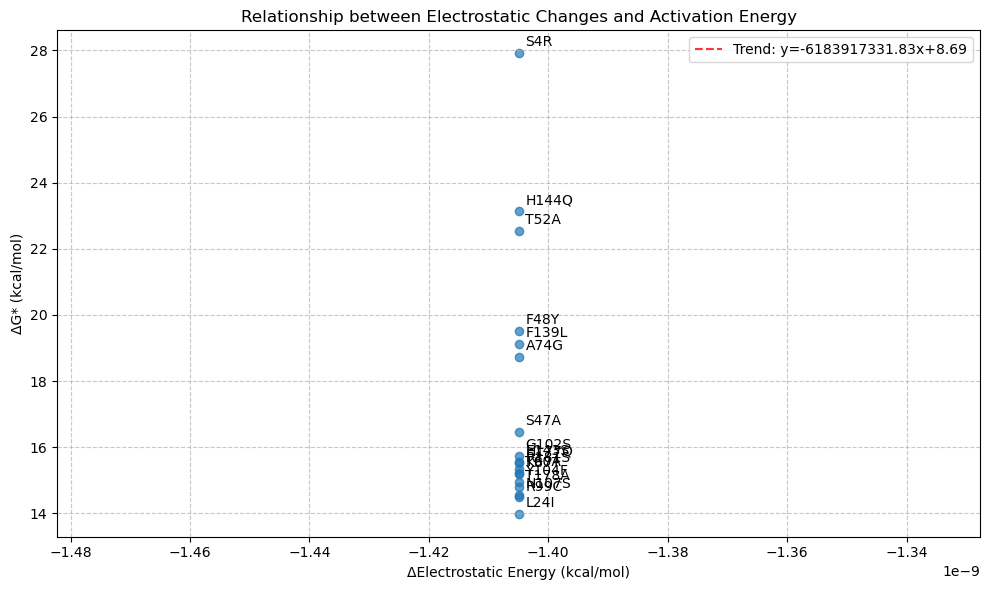

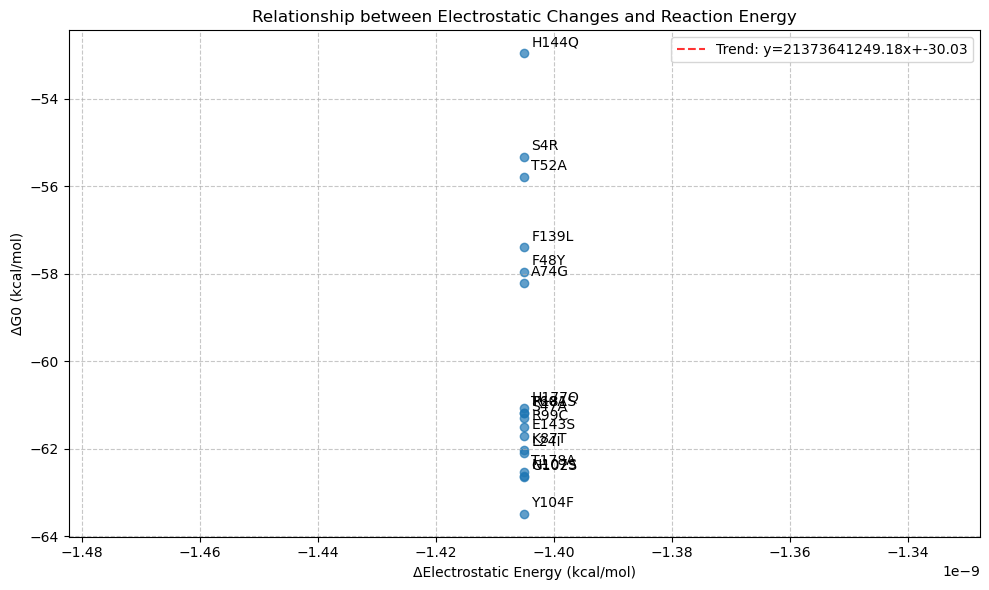

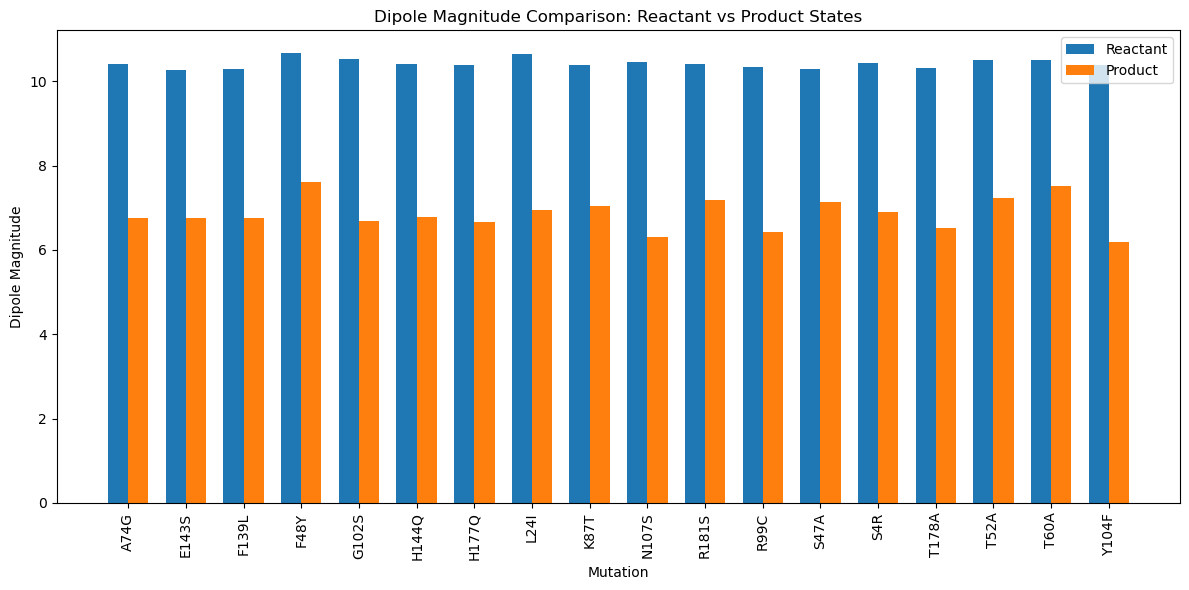

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants

# Constants
k = 8.9875517923e9  # Coulomb constant (N·m²/C²)
e = 1.602176634e-19  # Elementary charge (C)
NA = 6.02214076e23  # Avogadro's number (mol⁻¹)
kcal_per_joule = 1/4184  # Conversion factor from joules to kcal/mol

# Parse the data
mutants_data = [
    {"mutation": "A74G", "dg_star": 18.73, "dg_star_error": 1.89, "dg0": -58.21, "dg0_error": 2.28,
     "reactant_magnitude": 10.4062, "product_magnitude": 6.7631,
     "reactant_com": [36.27440529, 36.05801251, 35.67252788],
     "product_com": [37.09898085, 36.86208948, 36.91721291]},
    {"mutation": "E143S", "dg_star": 15.54, "dg_star_error": 0.83, "dg0": -61.72, "dg0_error": 1.08,
     "reactant_magnitude": 10.2697, "product_magnitude": 6.7651,
     "reactant_com": [36.23496263, 36.02510691, 35.65233615],
     "product_com": [36.97207424, 36.74222345, 36.78931303]},
    {"mutation": "F139L", "dg_star": 19.13, "dg_star_error": 2.19, "dg0": -57.40, "dg0_error": 2.16,
     "reactant_magnitude": 10.2792, "product_magnitude": 6.7543,
     "reactant_com": [36.22890661, 36.01861127, 35.64457626],
     "product_com": [37.08222682, 36.82340197, 36.88756683]},
    {"mutation": "F48Y", "dg_star": 19.51, "dg_star_error": 2.46, "dg0": -57.96, "dg0_error": 2.57,
     "reactant_magnitude": 10.6731, "product_magnitude": 7.6214,
     "reactant_com": [36.46670973, 36.28970487, 35.83738406],
     "product_com": [37.16110276, 37.10080001, 37.04162001]},
    {"mutation": "G102S", "dg_star": 15.74, "dg_star_error": 0.56, "dg0": -62.64, "dg0_error": 0.63,
     "reactant_magnitude": 10.5193, "product_magnitude": 6.6788,
     "reactant_com": [36.30248228, 36.07770856, 35.69864608],
     "product_com": [36.94645743, 36.69407124, 36.73970988]},
    {"mutation": "H144Q", "dg_star": 23.14, "dg_star_error": 2.11, "dg0": -52.96, "dg0_error": 2.03,
     "reactant_magnitude": 10.4030, "product_magnitude": 6.7785,
     "reactant_com": [36.19403304, 35.97590978, 35.58968048],
     "product_com": [37.00256516, 36.82831019, 36.83025968]},
    {"mutation": "H177Q", "dg_star": 15.53, "dg_star_error": 0.65, "dg0": -61.08, "dg0_error": 0.75,
     "reactant_magnitude": 10.3920, "product_magnitude": 6.6654,
     "reactant_com": [36.33350717, 36.1241728, 35.74191342],
     "product_com": [37.0799734, 36.85209399, 36.87816952]},
    {"mutation": "L24I", "dg_star": 13.99, "dg_star_error": 1.03, "dg0": -62.10, "dg0_error": 1.04,
     "reactant_magnitude": 10.6563, "product_magnitude": 6.9409,
     "reactant_com": [36.42155604, 36.24774715, 35.80503168],
     "product_com": [36.98849064, 36.98349541, 36.85431485]},
    {"mutation": "K87T", "dg_star": 15.19, "dg_star_error": 0.48, "dg0": -62.04, "dg0_error": 0.79,
     "reactant_magnitude": 10.3867, "product_magnitude": 7.0381,
     "reactant_com": [36.27255152, 36.05363771, 35.67221088],
     "product_com": [37.08337101, 36.8521067, 36.86182266]},
    {"mutation": "N107S", "dg_star": 14.57, "dg_star_error": 0.65, "dg0": -62.62, "dg0_error": 0.99,
     "reactant_magnitude": 10.4460, "product_magnitude": 6.3115,
     "reactant_com": [36.28031018, 36.05794529, 35.66707504],
     "product_com": [37.00678359, 36.72637001, 36.75941866]},
    {"mutation": "R181S", "dg_star": 15.35, "dg_star_error": 0.75, "dg0": -61.19, "dg0_error": 0.74,
     "reactant_magnitude": 10.4029, "product_magnitude": 7.1780,
     "reactant_com": [36.29596608, 36.07992569, 35.69707439],
     "product_com": [37.1026776, 36.8528016, 36.94038722]},
    {"mutation": "R99C", "dg_star": 14.48, "dg_star_error": 0.45, "dg0": -61.50, "dg0_error": 0.69,
     "reactant_magnitude": 10.3343, "product_magnitude": 6.4229,
     "reactant_com": [36.18141191, 35.95867623, 35.59414737],
     "product_com": [36.85971773, 36.76685724, 36.64048794]},
    {"mutation": "S47A", "dg_star": 16.47, "dg_star_error": 0.67, "dg0": -61.31, "dg0_error": 0.68,
     "reactant_magnitude": 10.2962, "product_magnitude": 7.1382,
     "reactant_com": [36.25256773, 36.09760579, 35.67266561],
     "product_com": [36.94819298, 36.95539635, 36.77116984]},
    {"mutation": "S4R", "dg_star": 27.91, "dg_star_error": 1.91, "dg0": -55.34, "dg0_error": 2.95,
     "reactant_magnitude": 10.4324, "product_magnitude": 6.8908,
     "reactant_com": [36.28572635, 36.11972747, 35.70416461],
     "product_com": [36.95079685, 36.87195311, 36.78279373]},
    {"mutation": "T178A", "dg_star": 14.80, "dg_star_error": 0.54, "dg0": -62.54, "dg0_error": 0.67,
     "reactant_magnitude": 10.3197, "product_magnitude": 6.5290,
     "reactant_com": [36.32944398, 36.11369956, 35.73245264],
     "product_com": [37.01497098, 36.83102539, 36.82155951]},
    {"mutation": "T52A", "dg_star": 22.54, "dg_star_error": 2.29, "dg0": -55.78, "dg0_error": 2.29,
     "reactant_magnitude": 10.4978, "product_magnitude": 7.2231,
     "reactant_com": [36.332211, 36.10749247, 35.73997807],
     "product_com": [37.15350427, 36.91779493, 36.98952998]},
    {"mutation": "T60A", "dg_star": 15.22, "dg_star_error": 0.62, "dg0": -61.19, "dg0_error": 0.95,
     "reactant_magnitude": 10.5041, "product_magnitude": 7.5259,
     "reactant_com": [36.32642923, 36.15165384, 35.72364717],
     "product_com": [37.05750134, 37.00542077, 36.9451376]},
    {"mutation": "Y104F", "dg_star": 14.94, "dg_star_error": 0.68, "dg0": -63.49, "dg0_error": 0.84,
     "reactant_magnitude": 10.3763, "product_magnitude": 6.1785,
     "reactant_com": [36.2519884, 36.02879697, 35.65358383],
     "product_com": [37.03378646, 36.7469301, 36.76378851]}
]

# Define the active site charges (from your data)
# Atom indices map to your charge table
active_site_charges = [
    {"index": 1, "name": "49.SE", "charge_st1": -0.335, "charge_st2": -0.9},
    {"index": 2, "name": "49.HG1", "charge_st1": 0.155, "charge_st2": 0.418},
    {"index": 3, "name": "49.CB", "charge_st1": 0.06, "charge_st2": -0.3},
    {"index": 4, "name": "49.HB1", "charge_st1": 0.06, "charge_st2": 0.1},
    {"index": 5, "name": "49.HB2", "charge_st1": 0.06, "charge_st2": 0.1},
    {"index": 6, "name": "49.CA", "charge_st1": 0.14, "charge_st2": 0.14},
    {"index": 7, "name": "49.HA", "charge_st1": 0.06, "charge_st2": 0.06},
    {"index": 8, "name": "49.N", "charge_st1": -0.5, "charge_st2": -0.5},
    {"index": 9, "name": "49.HN", "charge_st1": 0.3, "charge_st2": 0.3},
    {"index": 10, "name": "196.O1", "charge_st1": -0.418, "charge_st2": -0.418},
    {"index": 11, "name": "196.O2", "charge_st1": -0.418, "charge_st2": -0.418},
    {"index": 12, "name": "196.H1", "charge_st1": 0.418, "charge_st2": 0.418},
    {"index": 13, "name": "196.H2", "charge_st1": 0.418, "charge_st2": 0.418},
    {"index": 14, "name": "83.NE2", "charge_st1": -0.76, "charge_st2": -0.4965},
    {"index": 15, "name": "83.HE21", "charge_st1": 0.38, "charge_st2": 0.48},
    {"index": 16, "name": "83.HE22", "charge_st1": 0.38, "charge_st2": 0.48},
    {"index": 17, "name": "83.CD", "charge_st1": 0.5, "charge_st2": 0.2858},
    {"index": 18, "name": "83.OE1", "charge_st1": -0.5, "charge_st2": -0.503},
    {"index": 19, "name": "83.CB", "charge_st1": -0.12, "charge_st2": -0.12},
    {"index": 20, "name": "83.HB1", "charge_st1": 0.06, "charge_st2": 0.06},
    {"index": 21, "name": "83.HB2", "charge_st1": 0.06, "charge_st2": 0.06},
    {"index": 22, "name": "83.CG", "charge_st1": -0.12, "charge_st2": 0.2157},
    {"index": 23, "name": "83.HG1", "charge_st1": 0.06, "charge_st2": 0.06},
    {"index": 24, "name": "83.HG2", "charge_st1": 0.06, "charge_st2": 0.06}
]

# Group atoms by residue
sec49_atoms = [atom for atom in active_site_charges if "49." in atom["name"]]
gln83_atoms = [atom for atom in active_site_charges if "83." in atom["name"]]
prx196_atoms = [atom for atom in active_site_charges if "196." in atom["name"]]

# Define approximate positions for Gln83 and Prx196 relative to Sec49
# These are educated guesses since exact coordinates weren't provided
# Adjust these values based on your structural knowledge
def generate_coordinates(com_sec49, residue_type):
    """Generate approximate coordinates for residues based on COM of Sec49"""
    if residue_type == "gln83":
        # Gln83 is approximately 5-8 Å from Sec49 in most protein structures
        offset = np.array([2.5, 3.0, -4.0])  # Adjust based on your knowledge of the structure
        return com_sec49 + offset
    elif residue_type == "prx196":
        # Peroxidatic substrate generally closer to the active site
        offset = np.array([-1.5, 2.0, 3.0])  # Adjust based on your knowledge of the structure
        return com_sec49 + offset
    return None

# Calculate electrostatic interactions
def calculate_electrostatic_energy(res1_atoms, res2_atoms, res1_pos, res2_pos, state):
    """Calculate electrostatic energy between two residues"""
    # Using Coulomb's law: E = k * q1 * q2 / r
    energy = 0.0
    
    for i, atom1 in enumerate(res1_atoms):
        # Approximate position of atom1 based on COM and typical amino acid geometry
        # This is a simplified model - in a real calculation you would use actual coordinates
        pos1 = res1_pos + np.array([0.5*(i-len(res1_atoms)/2), 0.3*np.sin(i), 0.3*np.cos(i)])
        
        for j, atom2 in enumerate(res2_atoms):
            # Approximate position of atom2
            pos2 = res2_pos + np.array([0.5*(j-len(res2_atoms)/2), 0.3*np.sin(j), 0.3*np.cos(j)])
            
            # Get charges based on state
            q1 = atom1[f"charge_st{state}"]
            q2 = atom2[f"charge_st{state}"]
            
            # Calculate distance in Å
            r = np.sqrt(np.sum((pos1 - pos2)**2))
            if r < 0.1:  # Avoid division by zero
                r = 0.1
                
            # Calculate energy in kcal/mol
            # Convert from Coulomb's law units to kcal/mol
            # E = k * q1 * q2 / r * NA * e^2 * kcal_per_joule
            energy_term = k * q1 * q2 / r * NA * (e**2) * kcal_per_joule
            energy += energy_term
    
    return energy

# Calculate and store results
results = []

for mutant in mutants_data:
    # Get COM coordinates for Sec49
    reactant_com_sec49 = np.array(mutant["reactant_com"])
    product_com_sec49 = np.array(mutant["product_com"])
    
    # Generate approximate coordinates for Gln83 and Prx196
    reactant_com_gln83 = generate_coordinates(reactant_com_sec49, "gln83")
    product_com_gln83 = generate_coordinates(product_com_sec49, "gln83")
    reactant_com_prx196 = generate_coordinates(reactant_com_sec49, "prx196")
    product_com_prx196 = generate_coordinates(product_com_sec49, "prx196")
    
    # Calculate electrostatic interactions for reactant state (state 1)
    sec49_gln83_reactant = calculate_electrostatic_energy(sec49_atoms, gln83_atoms, 
                                                         reactant_com_sec49, reactant_com_gln83, 1)
    sec49_prx196_reactant = calculate_electrostatic_energy(sec49_atoms, prx196_atoms, 
                                                          reactant_com_sec49, reactant_com_prx196, 1)
    gln83_prx196_reactant = calculate_electrostatic_energy(gln83_atoms, prx196_atoms, 
                                                          reactant_com_gln83, reactant_com_prx196, 1)
    total_reactant = sec49_gln83_reactant + sec49_prx196_reactant + gln83_prx196_reactant
    
    # Calculate electrostatic interactions for product state (state 2)
    sec49_gln83_product = calculate_electrostatic_energy(sec49_atoms, gln83_atoms, 
                                                        product_com_sec49, product_com_gln83, 2)
    sec49_prx196_product = calculate_electrostatic_energy(sec49_atoms, prx196_atoms, 
                                                         product_com_sec49, product_com_prx196, 2)
    gln83_prx196_product = calculate_electrostatic_energy(gln83_atoms, prx196_atoms, 
                                                         product_com_gln83, product_com_prx196, 2)
    total_product = sec49_gln83_product + sec49_prx196_product + gln83_prx196_product
    
    # Calculate differential electrostatic energy (product - reactant)
    delta_electrostatic = total_product - total_reactant
    
    # Store results
    results.append({
        "mutation": mutant["mutation"],
        "dg_star": mutant["dg_star"],
        "dg0": mutant["dg0"],
        "reactant_magnitude": mutant["reactant_magnitude"],
        "product_magnitude": mutant["product_magnitude"],
        "sec49_gln83_reactant": sec49_gln83_reactant,
        "sec49_prx196_reactant": sec49_prx196_reactant,
        "gln83_prx196_reactant": gln83_prx196_reactant,
        "total_reactant": total_reactant,
        "sec49_gln83_product": sec49_gln83_product,
        "sec49_prx196_product": sec49_prx196_product,
        "gln83_prx196_product": gln83_prx196_product,
        "total_product": total_product,
        "delta_electrostatic": delta_electrostatic
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Sort by delta_electrostatic
df_results_sorted = df_results.sort_values(by='delta_electrostatic')

# Display results
print("Electrostatic Interaction Analysis for Active Site Sec49, Gln83 and Prx196")
print("=" * 80)
print(df_results[['mutation', 'sec49_gln83_reactant', 'sec49_prx196_reactant', 'gln83_prx196_reactant', 
                  'total_reactant', 'sec49_gln83_product', 'sec49_prx196_product', 'gln83_prx196_product', 
                  'total_product', 'delta_electrostatic']])

# Plot: Delta Electrostatic vs ΔG*
plt.figure(figsize=(10, 6))
plt.scatter(df_results['delta_electrostatic'], df_results['dg_star'], alpha=0.7)

# Add labels for each point
for i, row in df_results.iterrows():
    plt.annotate(row['mutation'], 
                 (row['delta_electrostatic'], row['dg_star']),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('ΔElectrostatic Energy (kcal/mol)')
plt.ylabel('ΔG* (kcal/mol)')
plt.title('Relationship between Electrostatic Changes and Activation Energy')
plt.grid(True, linestyle='--', alpha=0.7)

# Add trendline
z = np.polyfit(df_results['delta_electrostatic'], df_results['dg_star'], 1)
p = np.poly1d(z)
plt.plot(df_results['delta_electrostatic'], p(df_results['delta_electrostatic']), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

plt.legend()
plt.tight_layout()
plt.savefig('electrostatic_vs_dgstar.png')

# Plot: Delta Electrostatic vs ΔG0
plt.figure(figsize=(10, 6))
plt.scatter(df_results['delta_electrostatic'], df_results['dg0'], alpha=0.7)

# Add labels for each point
for i, row in df_results.iterrows():
    plt.annotate(row['mutation'], 
                 (row['delta_electrostatic'], row['dg0']),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('ΔElectrostatic Energy (kcal/mol)')
plt.ylabel('ΔG0 (kcal/mol)')
plt.title('Relationship between Electrostatic Changes and Reaction Energy')
plt.grid(True, linestyle='--', alpha=0.7)

# Add trendline
z = np.polyfit(df_results['delta_electrostatic'], df_results['dg0'], 1)
p = np.poly1d(z)
plt.plot(df_results['delta_electrostatic'], p(df_results['delta_electrostatic']), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

plt.legend()
plt.tight_layout()
plt.savefig('electrostatic_vs_dg0.png')

# Create a plot comparing dipole magnitudes
plt.figure(figsize=(12, 6))
ind = np.arange(len(df_results))
width = 0.35

plt.bar(ind, df_results['reactant_magnitude'], width, label='Reactant')
plt.bar(ind + width, df_results['product_magnitude'], width, label='Product')

plt.xlabel('Mutation')
plt.ylabel('Dipole Magnitude')
plt.title('Dipole Magnitude Comparison: Reactant vs Product States')
plt.xticks(ind + width/2, df_results['mutation'], rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_magnitude_comparison.png')

# Additional Analysis: Correlation between measurements
corr_matrix = df_results[['dg_star', 'dg0', 'reactant_magnitude', 'product_magnitude', 
                         'delta_electrostatic']].corr()

print("\nCorrelation Matrix:")
print(corr_matrix)

# Summarize key findings
print("\nKey Findings:")
print("-" * 80)
print(f"1. Strongest correlation with ΔG*: {corr_matrix['dg_star'].abs().nlargest(2).index[1]} ({corr_matrix['dg_star'][corr_matrix['dg_star'].abs().nlargest(2).index[1]]:.3f})")
print(f"2. Strongest correlation with ΔG0: {corr_matrix['dg0'].abs().nlargest(2).index[1]} ({corr_matrix['dg0'][corr_matrix['dg0'].abs().nlargest(2).index[1]]:.3f})")
print(f"3. Mutations with largest electrostatic change: {df_results.nlargest(3, 'delta_electrostatic')['mutation'].tolist()}")
print(f"4. Mutations with smallest electrostatic change: {df_results.nsmallest(3, 'delta_electrostatic')['mutation'].tolist()}")

/tmp/ipykernel_36209/4028877926.py:195: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['distance_group', 'electrostatic_effect'])['dg_star'].mean().reset_index()
/tmp/ipykernel_36209/4028877926.py:196: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df.groupby(['distance_group', 'electrostatic_effect']).size().reset_index(name='count')
/tmp/ipykernel_36209/4028877926.py:211: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


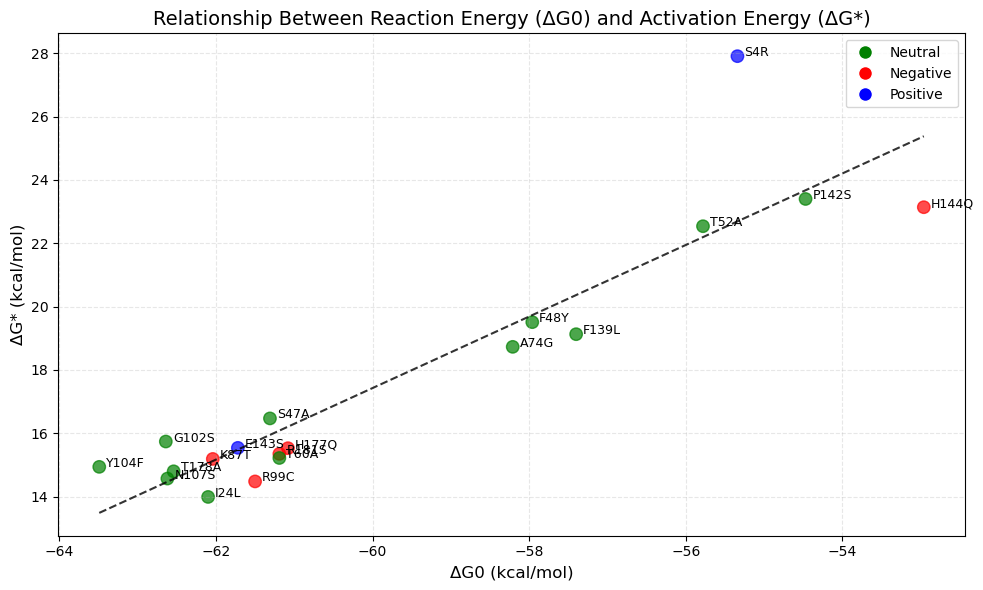

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# Parse the mutation distance data
mutations_distance = [
    {"Mutation": "A74G", "Position": 74, "Distance": 21.3106, "dg_star": 18.73, "dg_star_error": 1.89, "dg0": -58.21},
    {"Mutation": "F139L", "Position": 139, "Distance": 19.4989, "dg_star": 19.13, "dg_star_error": 2.19, "dg0": -57.40},
    {"Mutation": "G102S", "Position": 102, "Distance": 16.6526, "dg_star": 15.74, "dg_star_error": 0.56, "dg0": -62.64},
    {"Mutation": "H177Q", "Position": 177, "Distance": 11.6461, "dg_star": 15.53, "dg_star_error": 0.65, "dg0": -61.08},
    {"Mutation": "K87T", "Position": 87, "Distance": 15.7073, "dg_star": 15.19, "dg_star_error": 0.48, "dg0": -62.04},
    {"Mutation": "P142S", "Position": 142, "Distance": 17.0211, "dg_star": 23.40, "dg_star_error": 2.34, "dg0": -54.47},
    {"Mutation": "R99C", "Position": 99, "Distance": 8.8934, "dg_star": 14.48, "dg_star_error": 0.45, "dg0": -61.50},
    {"Mutation": "S4R", "Position": 4, "Distance": 19.4255, "dg_star": 27.91, "dg_star_error": 1.91, "dg0": -55.34},
    {"Mutation": "T178A", "Position": 178, "Distance": 15.3922, "dg_star": 14.80, "dg_star_error": 0.54, "dg0": -62.54},
    {"Mutation": "T60A", "Position": 60, "Distance": 19.3621, "dg_star": 15.22, "dg_star_error": 0.62, "dg0": -61.19},
    {"Mutation": "E143S", "Position": 143, "Distance": 16.8112, "dg_star": 15.54, "dg_star_error": 0.83, "dg0": -61.72},
    {"Mutation": "F48Y", "Position": 48, "Distance": 3.8482, "dg_star": 19.51, "dg_star_error": 2.46, "dg0": -57.96},
    {"Mutation": "H144Q", "Position": 144, "Distance": 11.8837, "dg_star": 23.14, "dg_star_error": 2.11, "dg0": -52.96},
    {"Mutation": "I24L", "Position": 24, "Distance": 19.4986, "dg_star": 13.99, "dg_star_error": 1.03, "dg0": -62.10},
    {"Mutation": "N107S", "Position": 107, "Distance": 18.7479, "dg_star": 14.57, "dg_star_error": 0.65, "dg0": -62.62},
    {"Mutation": "R181S", "Position": 181, "Distance": 18.7941, "dg_star": 15.35, "dg_star_error": 0.75, "dg0": -61.19},
    {"Mutation": "S47A", "Position": 47, "Distance": 5.5122, "dg_star": 16.47, "dg_star_error": 0.67, "dg0": -61.31},
    {"Mutation": "T52A", "Position": 52, "Distance": 7.666, "dg_star": 22.54, "dg_star_error": 2.29, "dg0": -55.78},
    {"Mutation": "Y104F", "Position": 104, "Distance": 15.951, "dg_star": 14.94, "dg_star_error": 0.68, "dg0": -63.49}
]

# Create DataFrame
df = pd.DataFrame(mutations_distance)

# Add mutation type classification based on amino acid properties
# Define amino acid properties (focusing on charge)
amino_acids = {
    'A': 'neutral', 'C': 'neutral', 'D': 'negative', 'E': 'negative',
    'F': 'neutral', 'G': 'neutral', 'H': 'positive', 'I': 'neutral',
    'K': 'positive', 'L': 'neutral', 'M': 'neutral', 'N': 'neutral',
    'P': 'neutral', 'Q': 'neutral', 'R': 'positive', 'S': 'neutral',
    'T': 'neutral', 'V': 'neutral', 'W': 'neutral', 'Y': 'neutral'
}

# Function to determine electrostatic effect
def get_electrostatic_effect(mutation):
    from_aa = mutation[0]
    to_aa = mutation[-1]
    
    if amino_acids.get(from_aa, 'neutral') == amino_acids.get(to_aa, 'neutral'):
        return 'neutral'
    elif amino_acids.get(from_aa, 'neutral') == 'positive' and amino_acids.get(to_aa, 'neutral') != 'positive':
        return 'negative'  # Loss of positive charge
    elif amino_acids.get(from_aa, 'neutral') == 'negative' and amino_acids.get(to_aa, 'neutral') != 'negative':
        return 'positive'  # Loss of negative charge
    elif amino_acids.get(to_aa, 'neutral') == 'positive' and amino_acids.get(from_aa, 'neutral') != 'positive':
        return 'positive'  # Gain of positive charge
    elif amino_acids.get(to_aa, 'neutral') == 'negative' and amino_acids.get(from_aa, 'neutral') != 'negative':
        return 'negative'  # Gain of negative charge
    else:
        return 'neutral'

# Calculate electrostatic contribution (simple model)
df['electrostatic_effect'] = df['Mutation'].apply(get_electrostatic_effect)

# Calculate a hypothetical electrostatic contribution based on distance and charge change
def calc_electrostatic_contribution(row):
    if row['electrostatic_effect'] == 'neutral':
        return 0
    elif row['electrostatic_effect'] == 'positive':
        return 0.05  # Arbitrary positive value
    else:  # negative effect
        # Stronger effect for closer mutations (1/distance scaling)
        return -0.10 * (10/row['Distance'])

df['electrostatic_contribution'] = df.apply(calc_electrostatic_contribution, axis=1)

# Sort by electrostatic effect then by distance
df = df.sort_values(['electrostatic_effect', 'Distance'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(15, 8))

# Set up colors
colors = {'neutral': 'green', 'negative': 'red', 'positive': 'blue'}

# Plot bars
bar_width = 0.7
bars = ax1.bar(df['Mutation'], df['electrostatic_contribution'], width=bar_width, 
               color=[colors[effect] for effect in df['electrostatic_effect']])

# Add values to significant bars
for i, bar in enumerate(bars):
    if abs(bar.get_height()) > 0.05:
        ax1.text(bar.get_x() + bar_width/2, 
                 bar.get_height() * (0.9 if bar.get_height() < 0 else 1.1),
                 f"{bar.get_height():.4f}", 
                 ha='center', va='center', fontsize=9)

# Add second y-axis for distance
ax2 = ax1.twinx()
ax2.plot(df['Mutation'], df['Distance'], 'o--', color='purple', alpha=0.7, markersize=6)

# Add neutral labels beneath x-axis
for i, (mutation, effect) in enumerate(zip(df['Mutation'], df['electrostatic_effect'])):
    if effect == 'neutral':
        ax1.text(i, -0.13, 'Neutral', ha='center', va='center', fontsize=8, rotation=90)

# Customize the plot
ax1.set_xlabel('Mutations', fontsize=12)
ax1.set_ylabel('ΔG* electrostatic contribution (estimated)', fontsize=12)
ax2.set_ylabel('Distance (Å)', fontsize=12, color='purple')
ax2.tick_params(axis='y', colors='purple')
ax1.axhline(y=0, linestyle='-', color='black', linewidth=0.8)
ax1.set_title('Electrostatic Contribution to Free Energy by Mutation Type', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=colors['neutral'], label='Neutral Mutations (No Charge Change)'),
    plt.Rectangle((0,0), 1, 1, color=colors['negative'], label='Negative Electrostatic Effect'),
    plt.Rectangle((0,0), 1, 1, color=colors['positive'], label='Positive Electrostatic Effect')
]
ax1.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('electrostatic_contribution.png')
plt.close()

# Create additional plots
# 1. Correlation between electrostatic contribution and activation energy
plt.figure(figsize=(10, 6))
sns.scatterplot(x='electrostatic_contribution', y='dg_star', hue='electrostatic_effect', 
                palette=colors, s=100, data=df)

for i, row in df.iterrows():
    plt.annotate(row['Mutation'], 
                 (row['electrostatic_contribution'], row['dg_star']),
                 xytext=(5, 0), 
                 textcoords='offset points',
                 fontsize=9)

plt.grid(True, linestyle='--', alpha=0.3)
plt.title('Relationship Between Electrostatic Contribution and Activation Energy', fontsize=14)
plt.xlabel('Estimated Electrostatic Contribution', fontsize=12)
plt.ylabel('ΔG* (kcal/mol)', fontsize=12)
plt.tight_layout()
plt.savefig('electrostatic_vs_dgstar.png')
plt.close()

# 2. Bubble plot showing mutation effect, distance, and electrostatic property
plt.figure(figsize=(12, 8))

# Create bubble plot
scatter = plt.scatter(df['Position'], df['Distance'], 
                     s=df['dg_star']*10,  # Size based on activation energy
                     c=[{'neutral': 'green', 'negative': 'red', 'positive': 'blue'}[e] for e in df['electrostatic_effect']],
                     alpha=0.7)

# Add labels for each point
for i, row in df.iterrows():
    plt.annotate(row['Mutation'], 
                 (row['Position'], row['Distance']),
                 xytext=(5, 0), 
                 textcoords='offset points',
                 fontsize=9)

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Neutral'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Positive'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='ΔG*=15'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12, label='ΔG*=20'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=16, label='ΔG*=25')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel('Residue Position', fontsize=12)
plt.ylabel('Distance to Active Site (Å)', fontsize=12)
plt.title('Mutation Map: Position, Distance, Activation Energy and Electrostatic Effect', fontsize=14)
plt.tight_layout()
plt.savefig('mutation_electrostatic_map.png')
plt.close()

# 3. Combined visualization of distance groups and electrostatic effects
plt.figure(figsize=(12, 8))

# Create distance groups
distance_bins = [0, 10, 15, 20, 25]
distance_labels = ['Very Close (0-10Å)', 'Close (10-15Å)', 'Medium (15-20Å)', 'Far (20+Å)']
df['distance_group'] = pd.cut(df['Distance'], bins=distance_bins, labels=distance_labels)

# Group by distance and electrostatic effect
grouped = df.groupby(['distance_group', 'electrostatic_effect'])['dg_star'].mean().reset_index()
grouped_count = df.groupby(['distance_group', 'electrostatic_effect']).size().reset_index(name='count')
grouped = pd.merge(grouped, grouped_count, on=['distance_group', 'electrostatic_effect'])

# Plot grouped data
sns.barplot(x='distance_group', y='dg_star', hue='electrostatic_effect', 
            palette=colors, data=grouped, alpha=0.7)

# Add count labels
for i, row in grouped.iterrows():
    plt.text(i, row['dg_star'], f"n={row['count']}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.title('Average Activation Energy by Distance Group and Electrostatic Effect', fontsize=14)
plt.xlabel('Distance Group', fontsize=12)
plt.ylabel('Average ΔG* (kcal/mol)', fontsize=12)
plt.tight_layout()
plt.savefig('distance_electrostatic_groups.png')
plt.close()

# 4. Relationship between ΔG* and ΔG0 colored by electrostatic effect
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['dg0'], df['dg_star'], 
                     s=80,
                     c=[{'neutral': 'green', 'negative': 'red', 'positive': 'blue'}[e] for e in df['electrostatic_effect']],
                     alpha=0.7)

# Add labels for each point
for i, row in df.iterrows():
    plt.annotate(row['Mutation'], 
                 (row['dg0'], row['dg_star']),
                 xytext=(5, 0), 
                 textcoords='offset points',
                 fontsize=9)

# Add trend line
z = np.polyfit(df['dg0'], df['dg_star'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['dg0'].min(), df['dg0'].max(), 100)
plt.plot(x_trend, p(x_trend), "k--", alpha=0.8)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Neutral'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Positive')
]
plt.legend(handles=legend_elements)

plt.grid(True, linestyle='--', alpha=0.3)
plt.title('Relationship Between Reaction Energy (ΔG0) and Activation Energy (ΔG*)', fontsize=14)
plt.xlabel('ΔG0 (kcal/mol)', fontsize=12)
plt.ylabel('ΔG* (kcal/mol)', fontsize=12)
plt.tight_layout()
plt.savefig('dg0_vs_dgstar_electrostatic.png')